In [3]:
import s3fs
import xarray as xr
import matplotlib.pyplot as plt

# 1. Connect to S3
fs = s3fs.S3FileSystem(anon=True)

# 2. Path to the annual mosaics (based on your output)
base_path = 'its-live-data/velocity_mosaic/v2/annual'

# 3. List all files in the folder
all_files = fs.ls(base_path)

# 4. FILTER: Select only files for Region 14 (Pakistan/Karakoram)
# We look for "RGI14A" in the filename.
# (Note: If you need Hindu Kush, you might also look for RGI13A)
pakistan_files = [f for f in all_files if 'RGI14A' in f and f.endswith('.nc')]

print(f"Found {len(pakistan_files)} annual files for Pakistan (RGI14).")

# 5. Pick the most recent year (e.g., 2022)
pakistan_files.sort()
latest_file_path = f"s3://{pakistan_files[-1]}"

print(f"Loading: {latest_file_path}")

# 6. Open the Dataset
# chunks are important here to avoid crashing your RAM
ds = xr.open_dataset(latest_file_path, engine='h5netcdf', chunks={'x': 2048, 'y': 2048})

print(ds)

# 7. Quick Plot to verify location
# This should show the Karakoram Anomaly area
plt.figure(figsize=(10, 6))
ds.v.plot(vmax=200, cmap='inferno')
plt.title("Pakistan/Karakoram Glacier Velocity (2022)")
plt.show()

Found 37 annual files for Pakistan (RGI14).
Loading: s3://its-live-data/velocity_mosaic/v2/annual/ITS_LIVE_velocity_120m_RGI14A_2022_v02.nc


ValueError: unrecognized engine 'h5netcdf' must be one of your download engines: ['store', 'zarr']. To install additional dependencies, see:
https://docs.xarray.dev/en/stable/user-guide/io.html 
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html

In [6]:


pip install h5py netCDF4

   ---------------------------------------- 0.0/2.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.9 MB ? eta -:--:--
   --- ------------------------------------ 0.3/2.9 MB ? eta -:--:--
   --- ------------------------------------ 0.3/2.9 MB ? eta -:--:--
   --- ------------------------------------ 0.3/2.9 MB ? eta -:--:--
   --- ------------------------------------ 0.3/2.9 MB ? eta -:--:--
   --- ------------------------------------ 0.3/2.9 MB ? eta -:--:--
   --- ---------------------------

In [2]:
import s3fs
import xarray as xr
import matplotlib.pyplot as plt
import time

# 1. Connect
print("1. Connecting to AWS S3...")
fs = s3fs.S3FileSystem(anon=True)
file_path = "its-live-data/velocity_mosaic/v2/annual/ITS_LIVE_velocity_120m_RGI14A_2022_v02.nc"

# 2. Open File Object
print("2. Opening file stream...")
file_obj = fs.open(file_path, mode='rb')

# 3. Load Metadata (Lazy)
print("3. Reading metadata (this should be fast)...")
ds = xr.open_dataset(file_obj, engine='h5netcdf', chunks={'x': 2048, 'y': 2048})

# CHECKPOINT: Print size
size_gb = ds.nbytes / 1e9
print(f"   -> Success! The full dataset is {size_gb:.2f} GB.")
print("   (If we plotted this whole thing, it would hang for 20+ minutes trying to download it.)")

# 4. The Fix: SUBSET before plotting
# We will slice a small window around the Baltoro Glacier (Central Karakoram)
# This reduces the download from 5GB to ~5MB.
print("4. Slicing specific region (Baltoro Glacier)...")

# Approximate pixel coordinates for Baltoro (you can use lat/lon later, this is faster for testing)
# We take a 1000x1000 pixel box from the middle-ish of the file
x_slice = slice(15000, 16000) 
y_slice = slice(10000, 11000)

subset = ds.v.isel(x=x_slice, y=y_slice)

print("5. Plotting subset...")
start = time.time()

plt.figure(figsize=(10, 6))
subset.plot(vmax=200, cmap='viridis')
plt.title(f"Test Plot: Baltoro Area (Loaded in {time.time()-start:.1f}s)")
plt.show()

print("--- DONE ---")

1. Connecting to AWS S3...
2. Opening file stream...
3. Reading metadata (this should be fast)...


KeyboardInterrupt: 

In [1]:
import requests
import os

# 1. Define URL (Note: We use the HTTPS link, not s3://, for direct download)
url = "https://its-live-data.s3.amazonaws.com/velocity_mosaic/v2/annual/ITS_LIVE_velocity_120m_RGI14A_2022_v02.nc"
filename = "ITS_LIVE_RGI14A_2022.nc"

print(f"Starting download of {filename}...")
print("This file is large (approx 3-5 GB). Please wait...")

# 2. Stream download with progress check
response = requests.get(url, stream=True)
total_size = int(response.headers.get('content-length', 0))

if response.status_code == 200:
    with open(filename, 'wb') as file:
        downloaded = 0
        chunk_size = 1024 * 1024  # 1MB chunks
        
        for data in response.iter_content(chunk_size=chunk_size):
            file.write(data)
            downloaded += len(data)
            
            # Simple progress bar
            percent = (downloaded / total_size) * 100
            print(f"\rDownloaded: {downloaded / 1e9:.2f} GB ({percent:.1f}%)", end="")
            
    print("\n\n--- Download Complete! ---")
else:
    print(f"Error: Server returned status {response.status_code}")

Starting download of ITS_LIVE_RGI14A_2022.nc...
This file is large (approx 3-5 GB). Please wait...
Downloaded: 0.05 GB (3.8%)

KeyboardInterrupt: 

--- Dataset Metadata ---
<xarray.Dataset> Size: 19GB
Dimensions:      (y: 17806, x: 26968)
Coordinates:
  * y            (y) float64 142kB 1.744e+06 1.744e+06 ... -3.921e+05 -3.922e+05
  * x            (x) float64 216kB -2.324e+06 -2.324e+06 ... 9.123e+05 9.124e+05
Data variables:
    mapping      <U1 4B ...
    landice      (y, x) float32 2GB ...
    floatingice  (y, x) float32 2GB ...
    count        (y, x) float64 4GB ...
    vx           (y, x) float32 2GB ...
    vy           (y, x) float32 2GB ...
    v            (y, x) float32 2GB ...
    v_error      (y, x) float32 2GB ...
    vx_error     (y, x) float32 2GB ...
    vy_error     (y, x) float32 2GB ...
Attributes:
    author:                            ITS_LIVE, a NASA MEaSUREs project (its...
    datacube_autoRIFT_parameter_file:  http://its-live-data.s3.amazonaws.com/...
    institution:                       NASA Jet Propulsion Laboratory (JPL), ...
    region:                            RGI14A
    year:                    

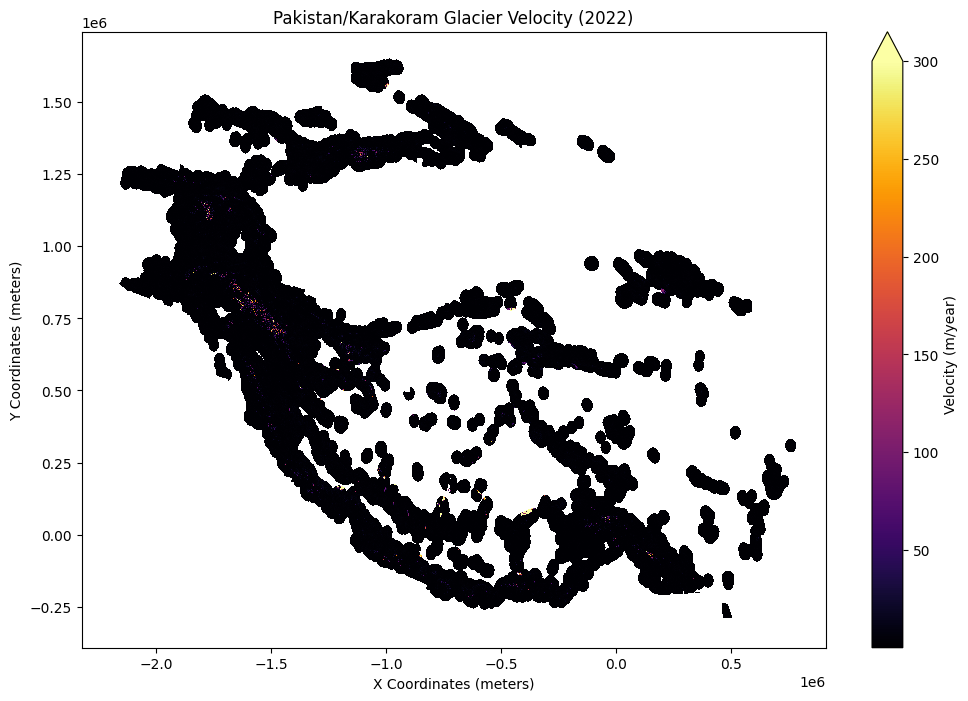

In [4]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

# 1. Define the filename (It must be in the same folder as this notebook)
filename = "ITS_LIVE_velocity_120m_RGI14A_2022_v02.nc"

# 2. Open the Dataset
# We use 'h5netcdf' engine. Since it's local, no chunks are strictly needed, 
# but they help if your RAM is low (8GB or less).
ds = xr.open_dataset(filename, engine='h5netcdf')

print("--- Dataset Metadata ---")
print(ds)

# 3. Visualize the Data (The "Map")
# We use a logarithmic scale because velocities vary wildly (10m/y to 500m/y)
plt.figure(figsize=(12, 8))

# v = velocity variable
# cmap='inferno' makes ice look bright yellow/orange against dark background
ds.v.plot(vmax=300, cmap='inferno', cbar_kwargs={'label': 'Velocity (m/year)'})

plt.title("Pakistan/Karakoram Glacier Velocity (2022)")
plt.xlabel("X Coordinates (meters)")
plt.ylabel("Y Coordinates (meters)")
plt.show()

In [9]:
import pandas as pd
import pyproj
import xarray as xr

# Load the file again if needed
filename = "ITS_LIVE_velocity_120m_RGI14A_2022_v02.nc"
ds = xr.open_dataset(filename, engine='h5netcdf')

# --- 1. SETUP COORDINATES (Dummy Data) ---
data = {
    'Name': ['Baltoro Glacier', 'Siachen Glacier', 'Biafo Glacier', 'Test Point'],
    'Lat': [35.75, 35.50, 36.00, 34.00], 
    'Lon': [76.50, 77.00, 75.90, 73.00]
}
df = pd.DataFrame(data)

# --- 2. FIX: FIND THE PROJECTION ---
try:
    # Option A: Look for 'crs_wkt' (Common in newer files)
    if 'crs_wkt' in ds.mapping.attrs:
        crs_wkt = ds.mapping.attrs['crs_wkt']
        proj_crs = pyproj.CRS.from_wkt(crs_wkt)
        print("Found projection in 'crs_wkt'")
        
    # Option B: Look for 'spatial_ref' (What you tried)
    elif 'spatial_ref' in ds.mapping.attrs:
        crs_wkt = ds.mapping.attrs['spatial_ref']
        proj_crs = pyproj.CRS.from_wkt(crs_wkt)
        print("Found projection in 'spatial_ref'")

    # Option C: Manual Fallback for Pakistan (RGI 14 is almost always EPSG:32643)
    else:
        print("Could not find WKT attribute. Using standard EPSG:32643 (UTM Zone 43N) for Pakistan.")
        proj_crs = pyproj.CRS.from_epsg(32643)

except Exception as e:
    print(f"Auto-detection failed ({e}). Forcing EPSG:32643.")
    proj_crs = pyproj.CRS.from_epsg(32643)

# --- 3. TRANSFORM LAT/LON TO X/Y ---
# Create transformer
transformer = pyproj.Transformer.from_crs("EPSG:4326", proj_crs, always_xy=True)

# Convert
xx, yy = transformer.transform(df['Lon'].values, df['Lat'].values)
df['x_proj'] = xx
df['y_proj'] = yy

# --- 4. EXTRACT VELOCITY ---
# Extract values
velocities = ds.v.sel(x=xr.DataArray(df['x_proj'], dims="points"), 
                      y=xr.DataArray(df['y_proj'], dims="points"), 
                      method='nearest')

df['velocity_m_y'] = velocities.values

print("\n--- Results ---")
print(df)

Found projection in 'crs_wkt'

--- Results ---
              Name    Lat   Lon        x_proj         y_proj  velocity_m_y
0  Baltoro Glacier  35.75  76.5 -1.510727e+06  747106.578453    146.804123
1  Siachen Glacier  35.50  77.0 -1.475746e+06  713750.003381    168.220474
2    Biafo Glacier  36.00  75.9 -1.553372e+06  782425.543189     51.431080
3       Test Point  34.00  73.0 -1.835551e+06  643098.071442           NaN


In [ ]:
pip install itslive